# Canada's Performance in Olympic in 60 years


Three different criteria for determining rank of countries in Olympic have been used to study the overall trend of Canada's performance in Olympic from 1960 to the date, both in summer games and in winter games. The first criteria is the total number of gold medals, which is usually used to determine the official rank of countries in Olympic games. The second criteria is the total number of medals, and the third criteria is the total number of medals per capita. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

**`athlete_events.csv`** dataset is taken from https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/version/2. It contains information about athletes competing in Olympic Games from 1896 to 2016. The medals table for Olympics 1960 to 2016 is derived from this dataset.

In [2]:
df=pd.read_csv('athlete_events.csv')
df.dropna(subset=['Medal'],inplace=True)
columns_to_keep=['Team', 'NOC', 'Games',
       'Year', 'Season', 'Sport', 'Event', 'Medal']
df= df[columns_to_keep]

# We have population info for after 1960 and pop. info makes no sense for Individual Olympic Athletes (with NOC 'IOA')
df=df[(df.Year>=1960)&(df.NOC !='IOA')]

#Unify the two Germanies, as the population data is cumulative for the two
df.NOC[df.NOC=='FRG']='GER'
df.NOC[df.NOC=='GDR']='GER'
df.Team[df.Team=='West Germany']='Germany'
df.Team[df.Team=='East Germany']='Germany'
# 1906 olympics is not recognized
#df=df[df.Year!= 1906]
unique=['Team','Games','Sport','Event']
df = df.set_index(unique)
df.reset_index(inplace=True)
df.drop_duplicates(inplace=True)
del df['Sport']
del df['Event']
del df['Year']
del df['Season']

<ipython-input-2-3b3ec34ee730>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.NOC[df.NOC=='GDR']='GER'
<ipython-input-2-3b3ec34ee730>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Team[df.Team=='East Germany']='Germany'


# Medals Table:

In [3]:
medals_table = df.groupby(['Games','NOC', 'Medal'],as_index=False).size()

medals_table = (medals_table.pivot_table(index=['Games', 'NOC'],columns=['Medal']).
            fillna(0).
            astype(int).
            droplevel(0,axis=1))

medals_table.columns.name = None
medals_table.reset_index(inplace=True)
medals_table = medals_table[['Games','NOC','Gold','Silver', 'Bronze']]
medals_table['Total']=medals_table.loc[:,'Gold':'Bronze'].sum(axis=1)

Medals table for Olympic 2018 and 2020 is taken from Wikipedia.

In [4]:
url='https://en.wikipedia.org/wiki/2018_Winter_Olympics_medal_table'
html = requests.get(url).content
df_list = pd.read_html(html)
df_2018 = df_list[2]
df_2018.rename(columns={'.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}NOC':'Team'},inplace=True)
del df_2018['Rank']
df_2018['Games']='2018 Winter'

url="https://en.wikipedia.org/wiki/2020_Summer_Olympics_medal_table"
html = requests.get(url).content
df_list = pd.read_html(html)
df_2020 = df_list[2]
del df_2020['Rank']
df_2020['Games']='2020 Summer'


pattern="([\w\s]*)(?:\s\()(\w{3})(?:.*)"
for df_recent in [df_2018, df_2020]:
    country_noc = df_recent['Team'].str.extract(pattern).dropna()
    df_recent['Team'], df_recent['NOC'] = country_noc[0], country_noc[1]
    #df_recent['NOC'] = country_noc[1]
    #df_recent.drop(columns=['Team'], inplace=True)
    df_recent.dropna(inplace=True)
    #df_recent=df_recent[['Games','NOC','Gold','Silver', 'Bronze','Total']] #seems to not be working. Why?!
df_2018=df_2018[['Games','NOC','Gold','Silver', 'Bronze','Total','Team']]
df_2020=df_2020[['Games','NOC','Gold','Silver', 'Bronze','Total','Team']]

In [5]:
medals_table = (medals_table.append(df_2018.loc[:,'Games':'Total'],ignore_index=True).
                append(df_2020.loc[:,'Games':'Total'],ignore_index=True))

In [6]:
def find_rank(df):
    df['Official_Rank']=df['tuple'].rank(method='min',ascending=False).astype(int)
    df['Rank_total_medals']=(df['Total']).rank(method='min',ascending=False).astype(int)
    return df

medals_table['tuple']=medals_table[['Gold', 'Silver', 'Bronze']].apply(tuple,axis=1)
medals_table = medals_table.groupby('Games').apply(find_rank)
del medals_table['tuple']

In [7]:
medals_table.to_csv('Olympics-medals-table 1960-2020.csv')

# Population of Countries

**`world-population.csv`** is taken from https://data.worldbank.org/indicator/SP.POP.TOTL. It contains the world population by country and year since 1960 to the date.

In [8]:
df_pop=(pd.read_csv('world-population.csv', skiprows=4).
        rename(columns={'Country Name':'Country_UN'}))

# NOC, country name table

In [9]:
noc_country=(df[['NOC','Team']].
             append(df_2018[['NOC','Team']],ignore_index=True).
             append(df_2020[['NOC','Team']],ignore_index=True).
             drop_duplicates().
             reset_index(drop=True))

             
def get_first_team(df):
    return df.Team.to_list()[0].split('-')[0]

noc_country=(noc_country.
             groupby('NOC',as_index=False).
             apply(get_first_team).
             rename(columns={None: 'Country_olympics'}))

In [10]:
countries_list_pop=df_pop['Country_UN'].to_list()

def find_country_in_df_pop(x):
    for country in countries_list_pop:
        if x in country:
            countries_list_pop.remove(country)
            return country
        
noc_country['Country_UN']=noc_country['Country_olympics'].apply(find_country_in_df_pop)

In [11]:
D={'Great Britain':'United Kingdom', 'United States Virgin Islands':'Virgin Islands (U.S.)',
   'Kyrgyzstan':'Kyrgyz Republic','South Korea':'Korea, Rep.', 'North Korea':"Korea, Dem. People's Rep.",
   'Slovakia':'Slovak Republic','ROC':'Russian Federation', 'Olympic Athletes from Russia':'Russian Federation'}
for key,value in D.items():
    noc_country.Country_UN[noc_country.Country_olympics==key]=value

# Relating Olympics and Population datasets

In [12]:
noc_country[noc_country.Country_UN.isna()]

,NOC,Country_olympics,Country_UN
1,AHO,Netherlands Antilles,None
38,EUN,Unified Team,None
105,SCG,Serbia and Montenegro,None
118,TCH,Czechoslovakia,None
123,TPE,Chinese Taipei,None
128,UAR,United Arab Republic,None
131,URS,Soviet Union,None
137,WIF,West Indies Federation,None
138,YUG,Yugoslavia,None


These countries are not listed in world population dataset, so we'll remove them:

In [13]:
nocs_deleted = noc_country.NOC[noc_country.Country_UN.isna()].to_list()
noc_country.dropna(inplace=True)

medals_table = medals_table[~medals_table.NOC.isin(nocs_deleted)]

In [14]:
medals_table = medals_table.merge(noc_country[['NOC','Country_UN']],how='left')

In [15]:
medals_table.to_csv('Olympics-medals-table 1960-2020.csv')

In [16]:
def find_pop(x):
    year= x.Games.split(' ')[0]
    country=x.Country_UN
    return int(df_pop[df_pop['Country_UN']==country][year].values[0])

medals_table['Population_mil']=medals_table.apply(find_pop,axis=1)/1000000

In [17]:
medals_table.Year = medals_table.Games.apply(lambda x:int(x.split(' ')[0]))
medals_table.Season = medals_table.Games.apply(lambda x:x.split(' ')[1])

<ipython-input-17-57960128dfd8>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  medals_table.Year = medals_table.Games.apply(lambda x:int(x.split(' ')[0]))
<ipython-input-17-57960128dfd8>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  medals_table.Season = medals_table.Games.apply(lambda x:x.split(' ')[1])


In [18]:
medals_table['Medal_per_capita'] = medals_table['Total']/medals_table['Population_mil']

In [19]:
def find_rank_capita(df):
    df['Rank_capita']=df['Medal_per_capita'].rank(method='min',ascending=False).astype(int)
    return df

medals_table=medals_table.groupby('Games').apply(find_rank_capita)

# Focus on Canada:

In [20]:
df_can= medals_table[['Games','Official_Rank', 'Rank_total_medals','Rank_capita','Medal_per_capita']][medals_table.NOC=='CAN'].reset_index(drop=True)

df_can['Season']=df_can['Games'].apply(lambda x:x.split(' ')[1])
df_can['Year'] = df_can['Games'].apply(lambda x:x.split(' ')[0])
df_can['Year'][df_can['Season']=='Summer']=df_can['Year'].apply(lambda x: x+' July 10')
df_can['Year'][df_can['Season']=='Winter']=df_can['Year'].apply(lambda x: x+' Feb 10')
df_can['Year']=pd.to_datetime(df_can['Year'])
df_can['Medal_per_capita'] *= 50
df_can.rename(columns={'Year':'Date', 'Medal_per_capita':'Medal per 20,000'},inplace=True)

<ipython-input-20-cca5c9f76b7a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_can['Year'][df_can['Season']=='Summer']=df_can['Year'].apply(lambda x: x+' July 10')
<ipython-input-20-cca5c9f76b7a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_can['Year'][df_can['Season']=='Winter']=df_can['Year'].apply(lambda x: x+' Feb 10')


In [21]:
df_can['Date']=pd.to_datetime(df_can['Date'])

In [22]:
df_can.to_csv('Canada in Olympics.csv')

In [23]:
df_can_winter=df_can[df_can.Season=='Winter']
df_can_summer=df_can[df_can.Season=='Summer']

In [24]:
import seaborn as sns

In [25]:
import matplotlib.gridspec as gridspec

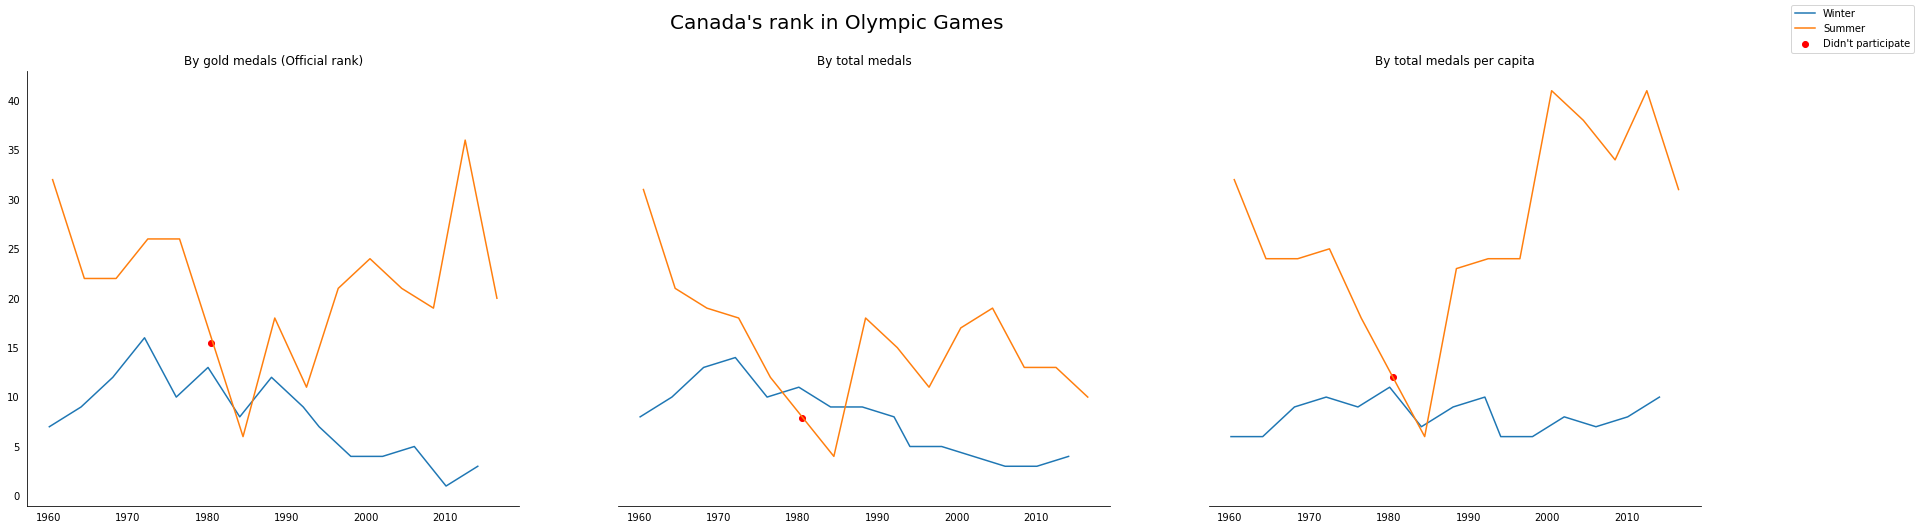

In [26]:
fig=plt.figure(figsize=(30,8));
ax1=fig.add_subplot(1,3,1);
ax2=fig.add_subplot(1,3,2,sharey=ax1);
ax3=fig.add_subplot(1,3,3,sharey=ax1);


ax1.plot(df_can_winter['Date'],df_can_winter['Official_Rank'],label='Winter');
ax1.plot(df_can_summer['Date'],df_can_summer['Official_Rank'],label='Summer');
#ax1.scatter(['1976-07-10', '1988-02-10','2010-02-10'],[26,12,1], color='g', label='Hosted in Canada');
ax1.scatter(['1980-07-10'],[15.5], color='r', label="Didn't participate");
ax1.set_title("By gold medals (Official rank)");


ax2.plot(df_can_winter['Date'],df_can_winter['Rank_total_medals'],label='Winter');
ax2.plot(df_can_summer['Date'],df_can_summer['Rank_total_medals'],label='Summer');
#ax2.scatter(['1976-07-10', '1988-02-10','2010-02-10'],[26,12,1], color='g', label='Hosted in Canada');
ax2.scatter(['1980-07-10'],[7.9], color='r', label="Didn't participate");
ax2.set_title("By total medals");


ax3.plot(df_can_winter['Date'],df_can_winter['Rank_capita'],label='Winter');
ax3.plot(df_can_summer['Date'],df_can_summer['Rank_capita'],label='Summer');
ax3.set_title("By total medals per capita");
#ax3.scatter(['1976-07-10', '1988-02-10','2010-02-10'],[18,9,8], color='g', label='Hosted in Canada');
ax3.scatter(['1980-07-10'],[12], color='r', label="Didn't participate");

for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    if ax in [ax2,ax3]:
        ax.spines['left'].set_visible(False)
        ax.axes.get_yaxis().set_visible(False)


fig.suptitle("Canada's rank in Olympic Games", fontsize=20);

# To make one legend for all subplots:
handles, labels = ax1.get_legend_handles_labels();
fig.legend(handles, labels,);


plt.savefig("Canada's performance in Olympic");

It is clear from the visual that in Winter games, Canada's rank  has been improving over the years if the applied criteria is the number of gold medals or the total number of medals. However, when the change in Canada's population over the years is taken into account, it is clear that the number of medals per capita have stayed almost steady over the years.

As for the Summer Games, it is clear that Canada's performance in the late 70s to early 90s has been substantially better than recent decades, with any of the three criteria. However, if we limit ourselves to the recent 20 years, a trend similar to Winter Games is observed: While the official rank and rank by total number of medals have improved, the rank by number of medals per capita has worsened over the 20-th century.